# 83강 특이값 분해 - 의사역행렬, 최소자승법

- 참고 사이트: [다크프로그래머블로그](https://darkpgmr.tistory.com/106)의 글을 읽으면서 정리한다.
- 의사 역행렬: Pseduo inverse
- 최소 자승법: lease square method, 기본 지식은 [쑤튜브 66강](https://www.youtube.com/watch?v=cjfpSs2Jgik)을 참고
- 특이값 분해를 이용하여 의사 역행렬을 만들 수도 있고,
- 의사 역행렬을 통해 최소자승법을 풀이 하는 과정에 대한 내용이다.


## TOC
- 개요
- 복습 - 정사영 개념을 이용한 최소제곱법
- 의사 역행렬 개념 - Pseudo Inverse
- 의사 역행렬로 선형시스템 문제 풀이의 예
    - 모델 결정
    - 모델로부터 결과 예측
- 모델 만드는 함수 정리
- truncated SVD 테스트

## 개요
- 연립일차방정식에서 
    1. 방정식이 미지수와 같아야 해를 구할 가능성이 있다.(determined)
    1. 방정식이 미지수보다 적으면 해가 무수히 많다.(underdetermined)
    1. **방정식이 미지수보다 많으면 해를 구할 수 없다.**
        - 이런 상황을 overdetermined system이라고 한다.([위키 참고](https://en.wikipedia.org/wiki/Overdetermined_system))

- **방정식이 미지수보다 많은 상태**, 즉 해를 구할 수 없는 상태에서, 근사해를 구하는 방법이 최소제곱법이다.
- 최소제곱법이 66강에서 정사영 개념을 이용한 방법만 있는줄 알았는데, 의사 역행렬로도 풀수 있다고 한다.

## 복습 - 정사영 개념을 이용한 최소제곱법
- 손으로 풀면 복잡하겠지만
- 그래프로 보면서 기억을 되살리자.
- 예전에 최소제곱법 공부할 때는 넘파이를 다룰 줄 몰라서 그래프를 못그렸었는데, 이제야 그려본다.

### 방정식이 미지수보다 많은 경우와 그 해
- 랜덤 데이터로 방정식이 미지수보다 많은 상황을 만든다.
- 원래는 $ y = 10x + 7 $의 직선인데, 
- 노이즈가 섞인 랜덤한 Y값들을 산점도로 표시했다.
- 랜덤한 데이터로부터 Best 직선을 찾은 결과는 원래의 직선과 대략 유사할 것이다.

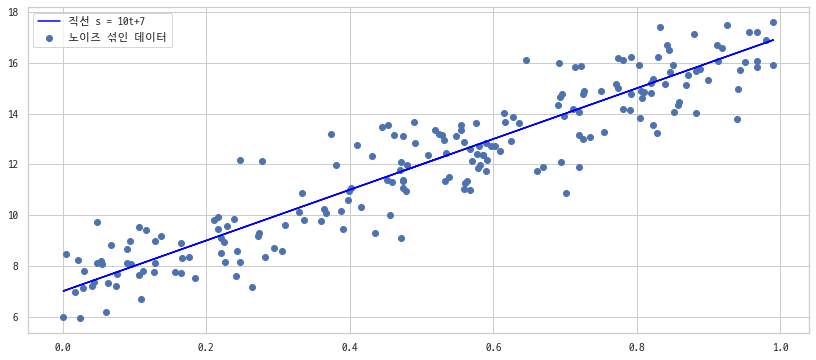

In [1]:
# s = 10t + 7의 직선 방정식으로 가정하자.
t = np.random.rand(200) # 샘플 데이터 200개 만들고
noise = np.random.randn(200) # 잡음 데이터
s = (10 * t + 7) + noise # 랜덤한 노이즈를 추가한다

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.scatter(t, s, label='노이즈 섞인 데이터')
ax.plot(t, 10*t+7, color='blue', label=f'직선 s = 10t+7')
ax.legend(loc='best')
plt.show()

### 점들을 행렬로 표현
- 위의 파랑선을 모른다고 가정하고
- 파랑점들로부터 파랑선과 유사하게 직선의 방정식을 추측해보자
- 알파벳이 햇갈리므로 $Ax=b$를 $Mw=v$로 생각해보자.

- 우리가 구하려고 하는 것 직선의 방정식을 찾는 것이므로
- 직선을 $ y = ax+b $ 형태로 생각하면 결국 a와 b를 구하려고 한다.
    - $Mw=v$에서 w는 $\dbinom{a}{b}$이고, $a$는 t의 계수, $b$는 y절편이 된다.
    - $Mw=v$에서 v는 y값이 된다.

- 어떤 한점 $(x_1,y_1)$은 $a x_1 + b = y_1 $ 형태이므로 행렬로는 $[x_1\;\; 1] \dbinom{a}{b} = {y_1}$ 형태가 된다.

- n개의 점을 행렬로 바꾸면 다음과 같다.
    - $M w = v $

$$
\begin{bmatrix}
    x_1     & 1 \\
    x_2     & 1 \\
    \vdots  & \vdots \\
    x_n     & 1 \\
\end{bmatrix}
\begin{bmatrix}
    a \\
    b \\
\end{bmatrix} 
= 
\begin{bmatrix}
    y_1      \\
    y_2      \\
    \vdots   \\
    y_n      \\
\end{bmatrix}
$$

### 기울기와 Y절편 찾기
- 점들을 행렬로 표현했더니 방정식이 미지수보다 많은 연립방정식이 되었다.
- 이런 경우를 overdetermined system이라고 한다.
- 위 상황을 최소제곱법으로 푸는  방법은 $ \hat {w} = (M^T M)^{-1} M^T v $

In [2]:
import numpy as np
from numpy.linalg import inv

def fit(x, y):
    M = np.c_[x, np.ones((x.shape[0], 1))] # 모든 x에 1을 추가한다.
    return inv(M.T @ M) @ M.T @ y


a, b = fit(x=t, y=s) # 기울기 a와 y절편 b를 구했다.
a, b

(9.748162362618489, 7.045352133225846)

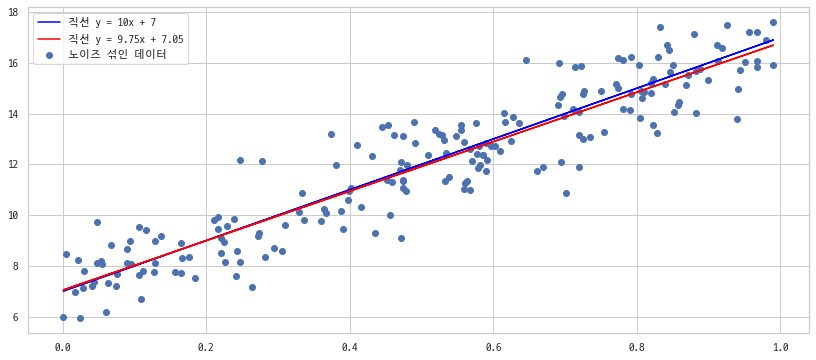

In [3]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.scatter(t, s, label='노이즈 섞인 데이터')
ax.plot(t, 10*t+7, color='blue', label=f'직선 y = 10x + 7')
ax.plot(t, a*t+b, color='red', label=f'직선 y = {round(a,2)}x + {round(b,2)}')
ax.legend(loc='best')
plt.show()

- 파랑선이 원래의 직선이고, 빨강선은 점들로부터 least square로 찾은 직선이다.
    - 랜덤한 데이터로부터 빨강선을 만들어 낸 것이므로 둘이 완전히 같을 경우는 거의 없다.
    - 대략 비슷할 뿐이다.

## 의사 역행렬 개념 - Pseudo Inverse
### 개념
- 선형 시스템 $Ax=b$가 있을 때, 만일 A의 역행렬이 존재한다면 이 시스템의 해 $x = A^{-1}b$로 손쉽게 구할 수 있다.
- 하지만 역행렬이 존재하지 않는 경우에는 의사 역행렬 $A^{+}$을 이용해서 $x = A^{+}b$와 같이 계산하고, 
- 이렇게 구한 해 x는 $\lVert Ax - b \rVert$를 최소화하는 해가 된다.
- 이렇게 의사 역행렬을 이용하여 해를 구하는 것은 최소자승법, least square method와 같은 의미가 된다.

### 의사역행렬과 특이값 분해
- 원래 역행렬은 정방행렬에 대해서만 정의된다. 하지만 의사역행렬은 임의의 직사각행렬에 대해서도 정의할 수 있으며
- 특이값 분해는 의사 역행렬을 계산하는 강력한 방법중 하나이다.
- 행렬 A의 특이값분해가 $A=U \Sigma V^T$라면 A의 의사역행렬은 $VE^{+}U^T$로 계산되고 $A^{+}$로 표기한다.
    - 단, $\Sigma^{+}$는 원래의 Σ에서 0이 아닌 특이값(singular value)들의 역수를 취한 후 전치 시킨 행렬이다.
    
$$ A = U \Sigma V^T  $$

$$ A^{+} = V \Sigma^{+} U^T  $$

$$ A = U
\begin{bmatrix}
    \sigma_1 &        & \\
             & \cdots & \\
             &        & \sigma_{s} \\
             &        & 0 \\
\end{bmatrix}_{\; m \times n} V^T \quad \Rightarrow \quad
A^{+} = V
\begin{bmatrix}
  1/\sigma_1 &        &              &   \\
             & \cdots &              &   \\
             &        & 1/\sigma_{s} & 0 \\
\end{bmatrix}_{\; n \times m}
U^T
$$

- U,V의 순서도 바뀌고, Σ도 $ m \times n $에서 $ n \times m $ 행렬로 바뀜에 주의하자.
- 만일 특이값들 중 0이 포함된 경우에는 0이 아닌 특이값들만 역수를 취하고 원래의 0은 $ \Sigma^{+} $에도 그대로 0으로 나둔다.
---

#### 참고사항1
- 만일 모든 특이값이 양수이고 m≥n이면 $A^{+}A$는 n x n 단위행렬(identity matrix)이 된다. 
- 만일 m≤n인 경우에는 $AA^+$가 단위행렬(m x m)이 된다. 
- 그리고 만일 0인 특이값이 포함되면 어떤 순서로 곱해도 단위행렬은 나오지 않는다.

---
$$
A^{+} A = (V \Sigma^{+} U^T)(U \Sigma V^T) = V \Sigma^{+} \Sigma V^T = VV^T = E_n \quad (m \ge n) \quad \cdots (5)
$$

---

$$
A A^{+} = (U \Sigma^{+} V^T)(V \Sigma U^T) = U \Sigma^{+} \Sigma U^T = UU^T = E_m \quad (m \le n) \quad \cdots (6)
$$

- 우리가 선형연립방정식에서 의사 역행렬을 적용하는 경우는 m≥n, 

- 즉 overdetermiend case로서 Ax=b의 양변에 $A^+$를 곱하여 
$A^{+}Ax = A^{+}b  \Rightarrow  x = A^{+}b$의 형태로 x를 구하는 것이다.

- m<n인 경우는 선형연립방정식으로 보면 미지수가 식의 개수가 많은 경우로서 해가 유일하게 결정되지 않는다. 
    - 이는 마치 점 2개를 가지고 평면을 결정하라는 문제와 같다. 
    - 따라서 특이값분해를 통해 의사 역행렬을 구하는 것은 m>n인 행렬을 대상으로 한다고 생각하는게 좋다.
    - m<n인 경우에도 pseudo inverse를 구할 수는 있지만 식 (6)과 같이 A의 뒤에 곱하는 형태로 사용해야 하므로 Ax=b 꼴 문제에는 유효하지 않다.


#### 참고사항2

- 특이값이 0이 아니더라도 0에 매우 가까운 경우에는 노이즈로 치고 0으로 바꾼 후에 pseudo inverse를 구하는 것이 일반적이다. 
- 즉, 어떤 행렬 A의 pseudo inverse를 SVD로 구하기 위해서는
    1. 먼저 특이값들을 구한 후에, 
    1. 0에 매우 가까운 특이값들은 0으로 바꾸고 
    1. 임계치 이상의 특이값들만 역수를 취해서 pseudo inverse를 구한다. 
- 이 임계치를 SVD의 tolerance라고 부르는데, matlab에서 사용하는 tolerance 기본값은 1e-10 이다. 
- 이는 앞서 설명한 truncated SVD와도 밀접한 관련이 있으며 어느 정도의 값을 노이즈로 볼 것인가에 따라서 
- 즉, tolerance 값을 어떻게 줄 것인가에 따라서 결과 pseudo inverse 및 선형시스템의 해가 달라질 수 있다. 
- 아래 예를 통해 tolerance 값에 따라서 선형시스템의 해가 어떻게 달라질 수 있는지 살펴보도록 하자.

## 의사 역행렬로 선형시스템 문제 풀이의 예

- 다음과 같은 문제가 있다.
>우리나라의 1930년 ~ 2010년 사이의 10년 단위의 연도별 인구추이를 보고 2020년도 총인구수를 예측하는 문제를 생각해 보자 

In [4]:
import pandas as pd
year = np.array([1930,1940,1949,1960,1970,1980,1990,2000,2010])
population = np.array([2044,2355,2017,2499,3144,3741,4339,4599,4799])
df = pd.DataFrame({'year':year, 'population':population})
df

,year,population
0,1930,2044
1,1940,2355
2,1949,2017
3,1960,2499
4,1970,3144
5,1980,3741
6,1990,4339
7,2000,4599
8,2010,4799


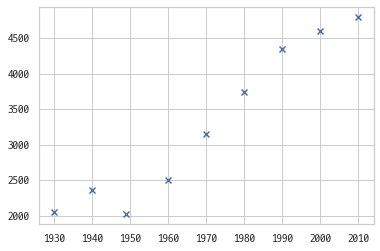

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(year, population, marker='x',label='연도별 인구')
plt.show()

### 모델 결정
- 예측하는 시스템이므로, 직선으로 할지, 2차 곡선으로 할지 결정한다.
- 모델의 방정식을 $y = a x^2 + b x + c  $로 잡자.

$$ 
a x_{1}^2 + b x_{1} + c = y_1 
\newline
a x_{2}^2 + b x_{2} + c = y_2
\newline
\cdots
\newline
a x_{9}^2 + b x_{9} + c = y_9
$$ 이므로

$$ Ax = b \quad \Rightarrow  \quad 
\begin{bmatrix}
    1930^2   & 1930   & 1      \\
    1940^2   & 1940   & 1      \\
    \vdots   & \vdots & \vdots \\
    2010^2   & 2010   & 1      \\
\end{bmatrix}_{\; 9x3}
\begin{bmatrix}
    a      \\
    b      \\
    c      \\
\end{bmatrix}
= 
\begin{bmatrix}
    2044   \\
    2355   \\
    \vdots \\
    4799   \\
\end{bmatrix}_{\; 9x1}
$$ 이렇게 행렬을 만들 수 있다.

- 행렬 A의 역행렬이 존재한다면 a,b,c를 바로 결정할 수 있다. 
- 하지만 위 그래프의 모든 점을 지나는 포물선은 존재하지 않을 것이므로
- 해는 존재하지 않고, A의 역행렬 또한 존재하지 않는다.
- 이런 경우 A의 의사역행렬 $A^+$를 구하여 $X=A^{+} B$로 X를 구하면 인구추이 데이터를 least square(최소자승)로 근사하는 포물선을 구할 수 있다.

#### 데이터로부터 A행렬을 만들고

In [6]:
A = np.vstack((year**2, year, np.ones((year.shape[0])))).T
A.shape

(9, 3)

#### A행렬의 특이값을 계산
- 9행 3열이므로 3개의 singular value를 얻을 수 있다. min(9행, 3열)=3개.

In [7]:
U,sigma,VT = np.linalg.svd(A)
U,sigma,VT
print("U =", U.shape)
print("sigma =", sigma)
print("transpose(V) =", VT.shape)

U = (9, 9)
sigma = [1.16474281e+07 7.76794286e+01 4.50781219e-04]
transpose(V) = (3, 3)


#### $A^{+}$를 계산
- $ A^{+} = V \Sigma^{+} U^T $

In [8]:
UT = U.T
V = VT.T
sigma_pinv = 1 / sigma
print('V.shape =', V.shape)
print('sigma_pseudo.shape =', sigma_pinv.shape)
print('UT.shape =', UT.shape)
nn = len(sigma_pinv)

A_pinv = V[:,:nn] @ np.diag(sigma_pinv[:nn]) @ UT[:nn, :]

print('A.shape =', A.shape)
print('A pseudo inverse.shape =', A_pinv.shape)


V.shape = (3, 3)
sigma_pseudo.shape = (3,)
UT.shape = (9, 9)
A.shape = (9, 3)
A pseudo inverse.shape = (3, 9)


#### 이렇게 $A^{+}$를 구했다. 이제 $x = A^{+}b$로 x 계산해보자.
- A는 9행 3열이고, $A^{+}$는 3행 9열
- 인구수(population)를 의미하는 b는 9행 1열이다.
- $A^{+}b$를 계산해보자. 계산결과는 3행 1열이겠다.

In [9]:
X_result = (A_pinv @ population)
X_result

array([ 2.13692684e-01, -8.02588922e+02,  7.54923065e+05])

- 모델의 방정식이 $y = a x^2 + b x + c  $이므로
- 최종 방정식은 다음과 같이 나온다.
- 표시를 위해 소숫점 3자리로 반올림 했지만, 실제 계산에서는 이렇게 하면 안된다.
    - 데이터가 년도라서 소숫점 3자리 반올림은 오차가 크다.(년도는 제곱하면 백만이 넘는다)

In [10]:
a = round(X_result[0],3)
b = round(X_result[1],3)
c = round(X_result[2],3)
print(f'y = {a}x^2 + {b}x + {c}')

y = 0.214x^2 + -802.589x + 754923.065


### 모델로부터 결과 예측
- 이를 이용해 연도를 입력받아 인구수를 예측하는 함수로 만들면 다음과 같다.

In [11]:
def predict(year):
    year = np.array(year)
    DATA = np.vstack((year**2, year, np.ones((year.shape[0])))).T
    return DATA @ X_result

# 이런식으로 예측할 수 있다.
pop_2020, pop_2030 = predict([2020, 2030])
print('2020년 인구수:', pop_2020)
print('2030년 인구수:', pop_2030)

2020년 인구수: 5645.071374721825
2030년 인구수: 6273.735865836497


#### 예측결과를 그래프로 표시해보자.
- 2030년을 예측 인구수를 그래프로 표시해보자

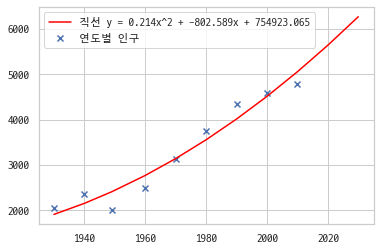

In [12]:
test_years = np.hstack((year,[2020,2030]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(year, population, marker='x',label='연도별 인구')
ax.plot(test_years, predict(test_years), color='red', label=f'직선 y = {a}x^2 + {b}x + {c}')
ax.legend(loc='best')
plt.show()


>1950, 1960년대는 전쟁과 베이비붐의 영향이 있어서 이상치 데이터로 볼 수 있다.

## 모델 만드는 함수 정리
1. 년도별 인구수에서, 년도 데이터를 행렬 A로 만들고
1. 산점도 그래프를 그려서 모델의 방정식을 $y = a x^2 + b x + c  $로 결정했다.
1. A를 특이값 분해하여 U, V, Singular values를 생성하고
1. $\Sigma^+$를 만들고, 의사 역행렬 $ A^{+} = V \Sigma^{+} U^T $를 생성한다.
1. 의사 역행렬 $ A^{+} $과 인구수 데이터를 곱하여 방정식의 계수 a,b,c를 알아낸다.

---

### 모델링 함수 만들기
- 위의 과정을 함수로 만들어보자.
- 짧은 함수지만 많은 지식이 함축되어 있다.

In [13]:
def fit(year, population, n):
    A = np.vstack((year**2, year, np.ones((year.shape[0])))).T
    U,sigma,VT = np.linalg.svd(A)
    UT = U.T
    V = VT.T
    sigma_pinv = 1 / sigma
    nn = np.min((n, len(sigma)))
    A_pinv = V[:,:nn] @ np.diag(sigma_pinv[:nn]) @ UT[:nn, :]
    coef_arr = (A_pinv @ population)
    return coef_arr

### 모델링 결과로 예측 함수 만들기
- 이전에 봤던 predict 함수와 동일하다.

In [14]:
def predict(year, coef_arr):
    year = np.array(year)
    DATA = np.vstack((year**2, year, np.ones((year.shape[0])))).T
    return DATA @ coef_arr

### 예측함수 호출
- 위에서 살펴본 SVD는 n이 3이었다(len(sigma)=3) 
- 그래서 full SVD 였다.

In [15]:
coef_arr = fit(year, population, n=3)
pop_2020, pop_2030 = predict([2020, 2030], coef_arr)
print('2020년 인구수:', pop_2020)
print('2030년 인구수:', pop_2030)

2020년 인구수: 5645.071374721825
2030년 인구수: 6273.735865836497


## truncated SVD 테스트
- 이제 N값에 따라 SVD로 근사할 수 있으므로
- truncated SVD를 테스트해보자.
    - N = 3이면 full SVD
    - N ≤ 2이면 truncated SVD이다.

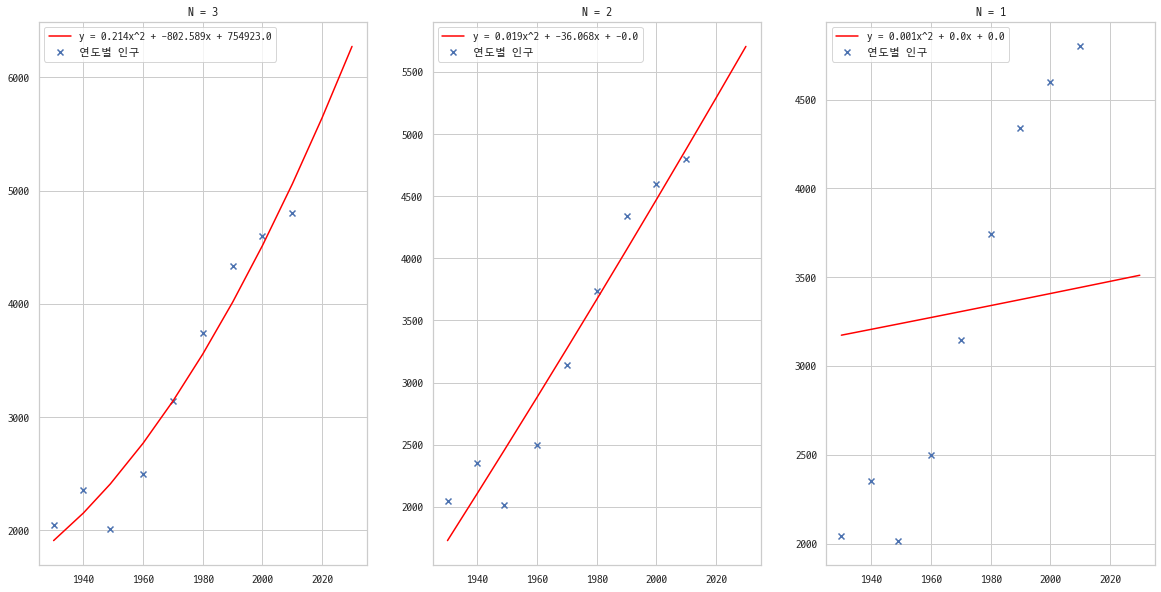

In [16]:
test_years = np.hstack((year,[2020,2030]))
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(w=20, h=10)
def do_plot(ax, title, n):
    coef_arr = fit(year, population, n=n)
    ax.scatter(year, population, marker='x',label='연도별 인구')
    ax.plot(test_years, 
            predict(test_years, coef_arr), 
            color='red', 
            label=f'y = {round(coef_arr[0],3)}x^2 + {round(coef_arr[1],3)}x + {round(coef_arr[2],0)}')
    ax.legend(loc='best')
    ax.set_title(title)

do_plot(ax[0], title=f'N = 3', n=3)
do_plot(ax[1], title=f'N = 2', n=2)
do_plot(ax[2], title=f'N = 1', n=1)
fig.show()

- 위의 그래프에서
    - 왼쪽은 full SVD
    - 가운데는 truncated SVD(N=2)
    - 오른쪽은 truncated SVD(N=1)이다.
- truncated SVD(N=2)는 full SVD에 비해 좀더 단순화된 모델로 데이터를 근사하는 것을 볼 수 있다.
- truncated SVD(N=1)는 더 단순화되었다.
- truncated SVD는 모델을 단순화시키면서 N값이 작아질 수록 데이터의 미세한 특성을 잃어버린다.
- truncated SVD가 섬세함을 잃어버렸지만 큰 흐름은 잡는 것을 볼 수 있다.
- 이미지 근사할때 N=1로 근사한 경우, 이미지 전체가 흐릿해서 거의 알 수 없지만, 그래도 전혀 엉뚱한 이미지가 아닌 것과 마찬가지다.

끝